# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1PDpAPg4MHJ76U4BC2jkaCaSCMnSqMbYj/view?usp=sharing

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# Define dataset path
dataset_path = "/content/gdrive/My Drive/APS360/Lab3 Dataset/Lab3_Gestures_Summer/"

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)

In [3]:
# Extract images and labels into separate lists
images = [dataset[i][0] for i in range(len(dataset))]  # Extract images as tensors
labels = [dataset[i][1] for i in range(len(dataset))]  # Extract labels as integers

# Convert to tensors
images = torch.stack(images)  # Stack tensors into a single tensor
labels = torch.tensor(labels)  # Convert labels to tensor

# Split the transformed data into training (70%) and temporary sets (30%)
images_train, images_temp, labels_train, labels_temp = train_test_split(images,
                        labels, test_size=0.3, random_state=42, stratify=labels)

# Split the temporary set into validation (15%) and testing sets (15%)
images_val, images_test, labels_val, labels_test = train_test_split(images_temp,
              labels_temp, test_size=0.5, random_state=42, stratify=labels_temp)

# Define Custom PyTorch Dataset
class CombinedDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Create Dataset Objects
train_dataset = CombinedDataset(images_train, labels_train)
valid_dataset = CombinedDataset(images_val, labels_val)
test_dataset = CombinedDataset(images_test, labels_test)

# Print dataset sizes
print("Training set size:", len(train_dataset))
print("Validation set size:", len(valid_dataset))
print("Testing set size:", len(test_dataset))

Training set size: 1553
Validation set size: 333
Testing set size: 333


To split the dataset, we first extracted all images and their corresponding labels using torchvision.datasets.ImageFolder. We then used train_test_split from sklearn.model_selection with stratified sampling to ensure a balanced class distribution. The data was divided into 70% training, 15% validation, and 15% testing, ensuring the validation and test sets represent unseen samples from the dataset.

### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class GestureCNN(nn.Module):
    def __init__(self):
        super(GestureCNN, self).__init__()

        # Convolutional layers and filters
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Compute flatten size dynamically
        self.flatten_size = self._get_flatten_size()

        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 9)  # 9 gesture classes

    def _get_flatten_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 128, 128)
            x = self.pool(F.relu(self.conv1(dummy_input)))
            x = self.pool(F.relu(self.conv2(x)))
            return x.view(1, -1).size(1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

I designed a CNN that consists of two convolutional layers with 16 and 32 filters, respectively, using 3×3 kernels and ReLU activation to extract spatial features. Each convolutional layer is followed by max pooling (2×2) to reduce dimensionality and retain essential patterns. The output is flattened and passed through a fully connected layer with 128 hidden units, incorporating dropout (0.3) for regularization. The final fully connected layer outputs predictions for 9 gesture classes.

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [5]:
import torch.optim as optim
import time
import matplotlib.pyplot as plt

def train_model(model, train_dataset, val_dataset,
                epochs=10, learning_rate=0.001,
                batch_size=32, checkpoint_path="gesture_model.pth"):

    # Create DataLoaders dynamically with the given batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Loss function & Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Learning rate scheduler (reduces LR every 5 epochs)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # Track metrics
    train_losses, val_losses, train_acc, val_acc = [], [], [], []
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()  # Enable training mode
        running_loss, correct, total = 0.0, 0, 0
        start_time = time.time()

        for batch_idx, (images, labels) in enumerate(train_loader, 1):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # Compute Train Loss & Accuracy
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracy = 100 * correct / total
        train_acc.append(train_accuracy)

        # Validation Phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracy = 100 * val_correct / val_total
        val_acc.append(val_accuracy)

        end_time = time.time()

        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, Time: {end_time - start_time:.2f}s")

        # Save best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch+1}")

        # Step the learning rate scheduler
        scheduler.step()

    # Plot Accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), train_acc, label="Train Accuracy", color="blue")
    plt.plot(range(1, epochs + 1), val_acc, label="Validation Accuracy", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.title("Training & Validation Accuracy")
    plt.show()

    # Plot Loss
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), train_losses, label="Train Loss", color="blue")
    plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Loss")
    plt.show()

We use CrossEntropyLoss because it is the standard loss function for multi-class classification, effectively measuring the difference between predicted probabilities and true labels. For optimization, we choose Adam due to its adaptive learning rates and momentum-based updates, which improve convergence speed and stability compared to standard SGD. Adam works well for CNNs, balancing efficiency and accuracy without extensive hyperparameter tuning.

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [6]:
from torch.utils.data import DataLoader, Subset
import random

def overfit_sanity_check(model, full_train_dataset, num_samples=20,
                         epochs=200, learning_rate=0.001):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Select a small random subset of images
    small_indices = random.sample(range(len(full_train_dataset)), num_samples)
    small_dataset = Subset(full_train_dataset, small_indices)

    # Use a large batch size (entire dataset in one batch)
    small_loader = DataLoader(small_dataset, batch_size=len(small_dataset),
                              shuffle=True)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"Overfitting test on {num_samples} images...")

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in small_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}: Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%")

        # Stop early if 100% accuracy is reached
        if train_acc == 100.0:
            print("Model successfully memorized the dataset!")
            break

In [7]:
model = GestureCNN()
overfit_sanity_check(model, train_dataset, num_samples=20, epochs=200, learning_rate=0.001)

Overfitting test on 20 images...
Epoch 1/200: Loss: 2.1917, Train Acc: 10.00%
Epoch 2/200: Loss: 2.1677, Train Acc: 20.00%
Epoch 3/200: Loss: 2.1766, Train Acc: 15.00%
Epoch 4/200: Loss: 1.8086, Train Acc: 40.00%
Epoch 5/200: Loss: 1.6594, Train Acc: 55.00%
Epoch 6/200: Loss: 1.4240, Train Acc: 70.00%
Epoch 7/200: Loss: 1.1600, Train Acc: 85.00%
Epoch 8/200: Loss: 1.1110, Train Acc: 65.00%
Epoch 9/200: Loss: 0.8898, Train Acc: 70.00%
Epoch 10/200: Loss: 0.7652, Train Acc: 75.00%
Epoch 11/200: Loss: 0.5346, Train Acc: 90.00%
Epoch 12/200: Loss: 0.4840, Train Acc: 90.00%
Epoch 13/200: Loss: 0.3765, Train Acc: 90.00%
Epoch 14/200: Loss: 0.2032, Train Acc: 100.00%
Model successfully memorized the dataset!


### 3. Hyperparameter Search [15 pt]

### Part (a) - 3 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

Model architecture related: kernel size

Non model architecture related: learning rate, number of epoches, batch size.

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

Epoch 1/10: Train Loss: 1.7893, Train Acc: 34.96%, Val Loss: 1.1996, Val Acc: 56.16%, Time: 23.64s
Checkpoint saved at epoch 1
Epoch 2/10: Train Loss: 1.1565, Train Acc: 59.63%, Val Loss: 1.0169, Val Acc: 64.86%, Time: 22.30s
Checkpoint saved at epoch 2
Epoch 3/10: Train Loss: 0.9196, Train Acc: 68.13%, Val Loss: 0.9137, Val Acc: 68.47%, Time: 21.89s
Checkpoint saved at epoch 3
Epoch 4/10: Train Loss: 0.7004, Train Acc: 75.53%, Val Loss: 0.8677, Val Acc: 70.57%, Time: 22.50s
Checkpoint saved at epoch 4
Epoch 5/10: Train Loss: 0.5663, Train Acc: 80.36%, Val Loss: 0.8202, Val Acc: 74.47%, Time: 23.10s
Checkpoint saved at epoch 5
Epoch 6/10: Train Loss: 0.3967, Train Acc: 86.48%, Val Loss: 0.8064, Val Acc: 74.47%, Time: 21.32s
Epoch 7/10: Train Loss: 0.3274, Train Acc: 89.38%, Val Loss: 0.7727, Val Acc: 76.28%, Time: 25.50s
Checkpoint saved at epoch 7
Epoch 8/10: Train Loss: 0.2543, Train Acc: 92.08%, Val Loss: 0.8348, Val Acc: 75.38%, Time: 25.83s
Epoch 9/10: Train Loss: 0.2166, Train Ac

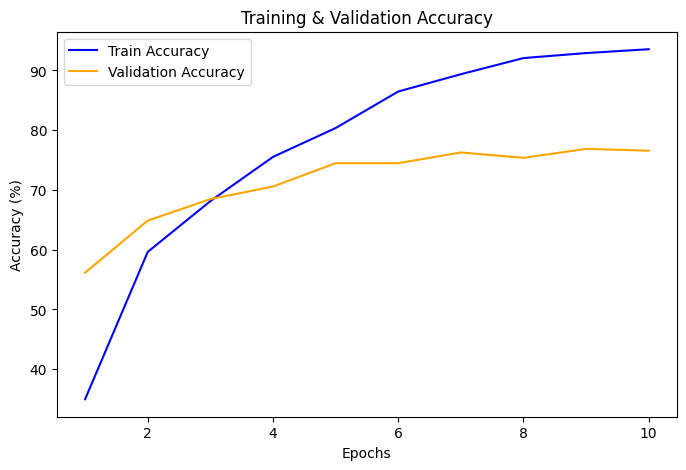

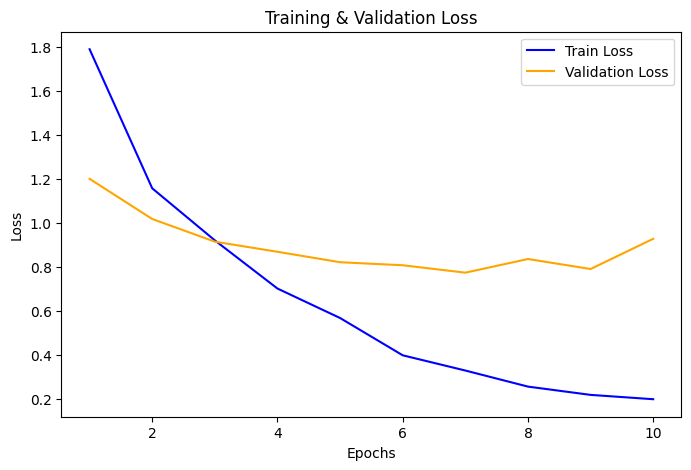

In [ ]:
# Learning Rate: 0.001
# Epoches: 10
# Batch Size: 32
# Kernel Size: 3x3
model1 = GestureCNN()
train_model(model1, train_dataset, valid_dataset, epochs=10,
            learning_rate=0.001, batch_size=32, checkpoint_path="model1.pth")

Epoch 1/10: Train Loss: 2.6730, Train Acc: 11.08%, Val Loss: 2.1965, Val Acc: 11.11%, Time: 25.86s
Checkpoint saved at epoch 1
Epoch 2/10: Train Loss: 2.1989, Train Acc: 11.33%, Val Loss: 2.1963, Val Acc: 11.41%, Time: 26.57s
Checkpoint saved at epoch 2
Epoch 3/10: Train Loss: 2.1987, Train Acc: 11.46%, Val Loss: 2.1962, Val Acc: 11.41%, Time: 22.87s
Epoch 4/10: Train Loss: 2.1988, Train Acc: 9.34%, Val Loss: 2.1960, Val Acc: 11.41%, Time: 24.98s
Epoch 5/10: Train Loss: 2.1985, Train Acc: 10.05%, Val Loss: 2.1964, Val Acc: 11.11%, Time: 23.51s
Epoch 6/10: Train Loss: 2.1977, Train Acc: 11.33%, Val Loss: 2.1963, Val Acc: 11.41%, Time: 22.55s
Epoch 7/10: Train Loss: 2.1977, Train Acc: 11.46%, Val Loss: 2.1962, Val Acc: 11.41%, Time: 23.39s
Epoch 8/10: Train Loss: 2.1979, Train Acc: 10.24%, Val Loss: 2.1963, Val Acc: 11.41%, Time: 23.07s
Epoch 9/10: Train Loss: 2.1978, Train Acc: 10.95%, Val Loss: 2.1962, Val Acc: 11.41%, Time: 22.51s
Epoch 10/10: Train Loss: 2.1980, Train Acc: 10.17%, Va

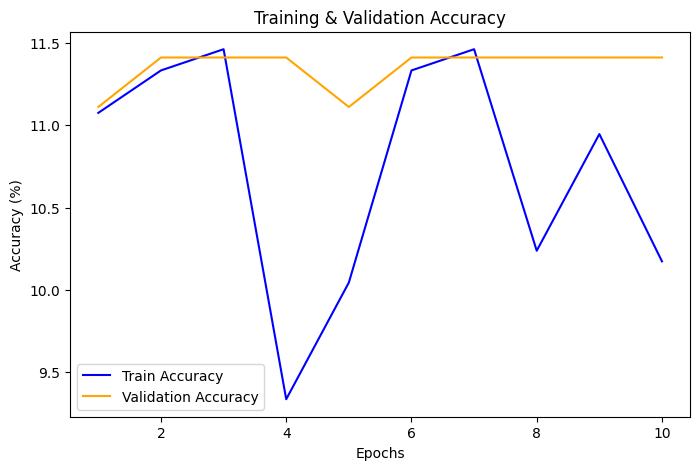

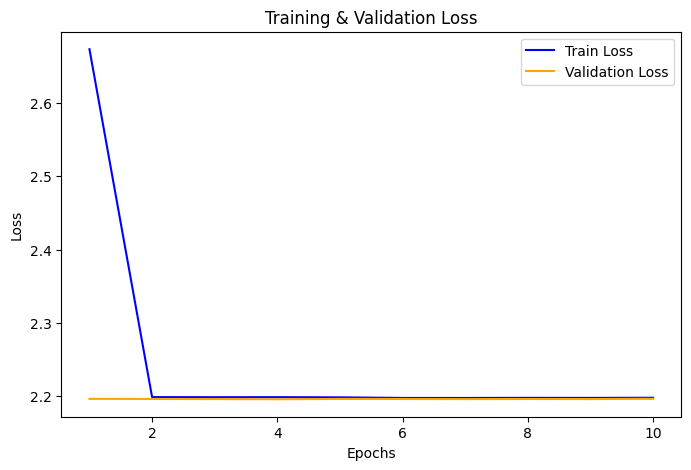

In [ ]:
# Learning Rate: 0.01
# Epoches: 10
# Batch Size: 32
# Kernel Size: 3x3
model2 = GestureCNN()
train_model(model2, train_dataset, valid_dataset, epochs=10,
            learning_rate=0.01, batch_size=32, checkpoint_path="model2.pth")

Epoch 1/20: Train Loss: 1.8722, Train Acc: 32.07%, Val Loss: 1.4128, Val Acc: 49.85%, Time: 24.82s
Checkpoint saved at epoch 1
Epoch 2/20: Train Loss: 1.2225, Train Acc: 57.37%, Val Loss: 1.0718, Val Acc: 61.86%, Time: 20.89s
Checkpoint saved at epoch 2
Epoch 3/20: Train Loss: 0.9567, Train Acc: 68.06%, Val Loss: 0.9549, Val Acc: 67.57%, Time: 23.85s
Checkpoint saved at epoch 3
Epoch 4/20: Train Loss: 0.7759, Train Acc: 73.08%, Val Loss: 0.9033, Val Acc: 68.47%, Time: 21.55s
Checkpoint saved at epoch 4
Epoch 5/20: Train Loss: 0.6479, Train Acc: 77.14%, Val Loss: 0.8509, Val Acc: 67.87%, Time: 21.67s
Epoch 6/20: Train Loss: 0.4751, Train Acc: 82.87%, Val Loss: 0.8422, Val Acc: 73.27%, Time: 21.66s
Checkpoint saved at epoch 6
Epoch 7/20: Train Loss: 0.3898, Train Acc: 85.96%, Val Loss: 0.7939, Val Acc: 78.08%, Time: 21.10s
Checkpoint saved at epoch 7
Epoch 8/20: Train Loss: 0.3273, Train Acc: 88.73%, Val Loss: 0.7710, Val Acc: 77.18%, Time: 22.12s
Epoch 9/20: Train Loss: 0.2780, Train Ac

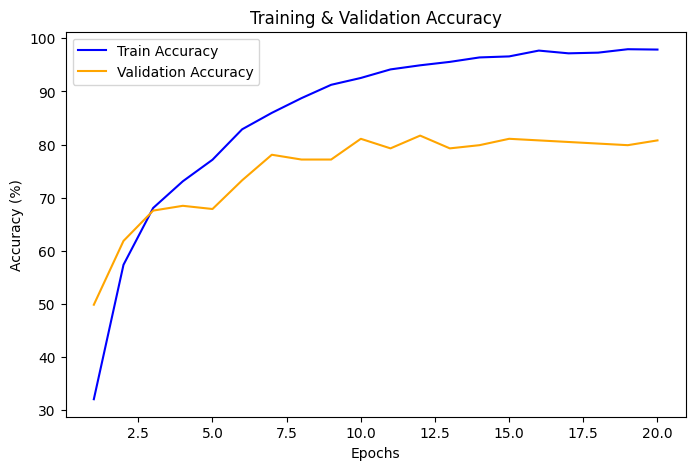

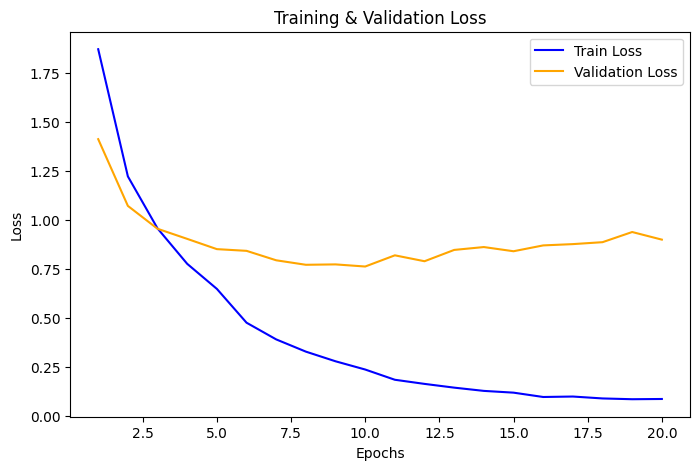

In [ ]:
# Learning Rate: 0.001
# Epoches: 20
# Batch Size: 32
# Kernel Size: 3x3
model3 = GestureCNN()
train_model(model3, train_dataset, valid_dataset, epochs=20,
            learning_rate=0.001, batch_size=32, checkpoint_path="model3.pth")

Epoch 1/20: Train Loss: 1.9155, Train Acc: 27.75%, Val Loss: 1.4556, Val Acc: 48.05%, Time: 30.04s
Checkpoint saved at epoch 1
Epoch 2/20: Train Loss: 1.3629, Train Acc: 51.13%, Val Loss: 1.1334, Val Acc: 62.76%, Time: 29.55s
Checkpoint saved at epoch 2
Epoch 3/20: Train Loss: 1.0462, Train Acc: 64.26%, Val Loss: 1.0267, Val Acc: 68.47%, Time: 29.39s
Checkpoint saved at epoch 3
Epoch 4/20: Train Loss: 0.8925, Train Acc: 69.29%, Val Loss: 0.9626, Val Acc: 68.47%, Time: 29.40s
Epoch 5/20: Train Loss: 0.7845, Train Acc: 72.18%, Val Loss: 0.9131, Val Acc: 69.97%, Time: 29.52s
Checkpoint saved at epoch 5
Epoch 6/20: Train Loss: 0.6281, Train Acc: 78.94%, Val Loss: 0.8713, Val Acc: 71.17%, Time: 29.58s
Checkpoint saved at epoch 6
Epoch 7/20: Train Loss: 0.5556, Train Acc: 82.03%, Val Loss: 0.8638, Val Acc: 73.87%, Time: 29.65s
Checkpoint saved at epoch 7
Epoch 8/20: Train Loss: 0.4736, Train Acc: 82.81%, Val Loss: 0.8751, Val Acc: 73.57%, Time: 30.46s
Epoch 9/20: Train Loss: 0.4459, Train Ac

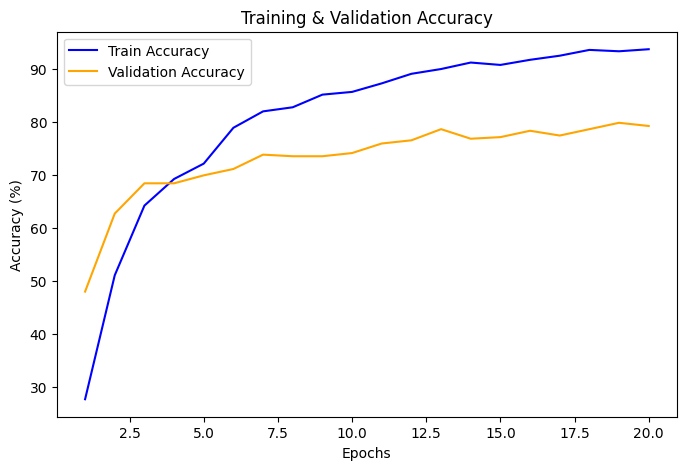

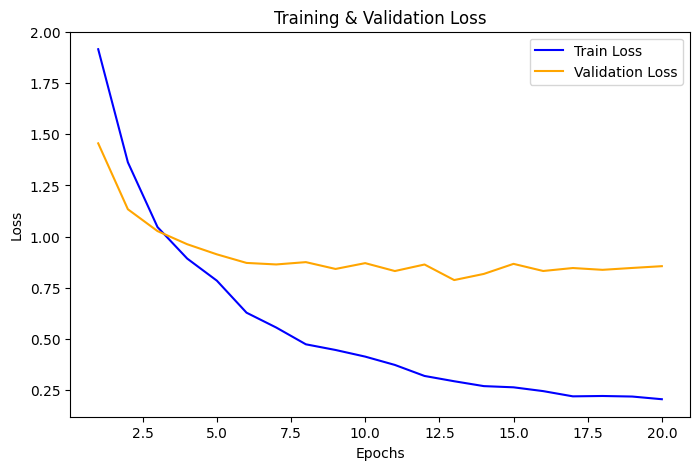

In [ ]:
# Learning Rate: 0.001
# Epoches: 20
# Batch Size: 64
# Kernel Size: 3x3
model4 = GestureCNN()
train_model(model4, train_dataset, valid_dataset, epochs=20,
            learning_rate=0.001, batch_size=64, checkpoint_path="model4.pth")

Epoch 1/20: Train Loss: 2.1478, Train Acc: 17.71%, Val Loss: 1.8812, Val Acc: 40.54%, Time: 31.58s
Checkpoint saved at epoch 1
Epoch 2/20: Train Loss: 1.6115, Train Acc: 43.53%, Val Loss: 1.3524, Val Acc: 60.06%, Time: 30.25s
Checkpoint saved at epoch 2
Epoch 3/20: Train Loss: 1.2386, Train Acc: 56.60%, Val Loss: 1.1240, Val Acc: 63.06%, Time: 25.98s
Checkpoint saved at epoch 3
Epoch 4/20: Train Loss: 1.0125, Train Acc: 65.55%, Val Loss: 1.0015, Val Acc: 67.57%, Time: 34.32s
Checkpoint saved at epoch 4
Epoch 5/20: Train Loss: 0.8429, Train Acc: 71.02%, Val Loss: 0.9311, Val Acc: 68.47%, Time: 28.27s
Checkpoint saved at epoch 5
Epoch 6/20: Train Loss: 0.7666, Train Acc: 73.54%, Val Loss: 0.8883, Val Acc: 69.97%, Time: 27.50s
Checkpoint saved at epoch 6
Epoch 7/20: Train Loss: 0.6676, Train Acc: 78.11%, Val Loss: 0.8462, Val Acc: 72.37%, Time: 28.32s
Checkpoint saved at epoch 7
Epoch 8/20: Train Loss: 0.5958, Train Acc: 80.30%, Val Loss: 0.8390, Val Acc: 73.57%, Time: 27.45s
Checkpoint s

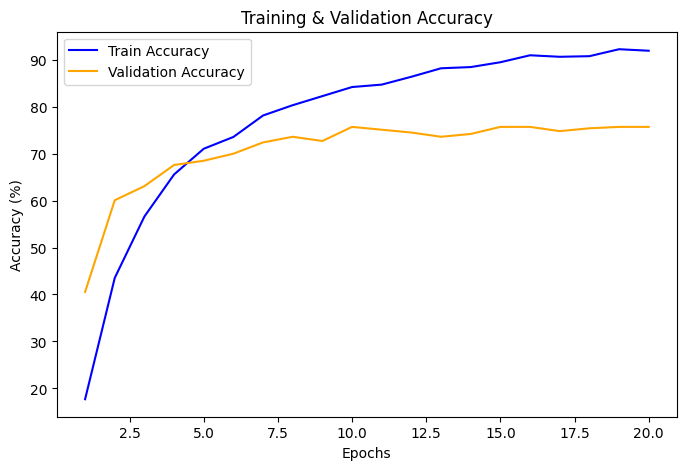

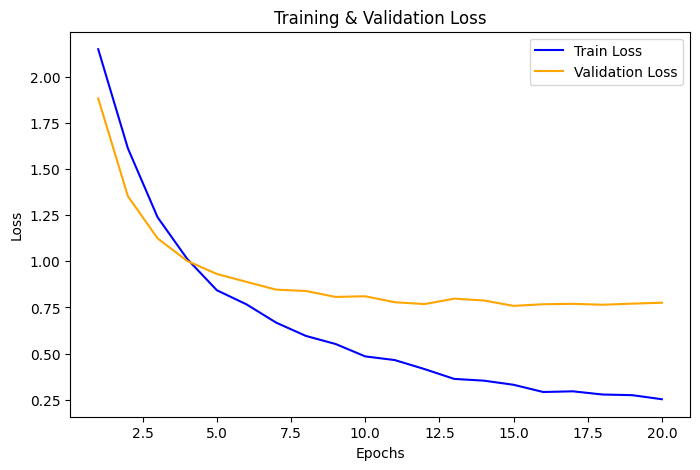

In [10]:
# Learning Rate: 0.001
# Epoches: 20
# Batch Size: 128
# Kernel Size: 3x3
model5 = GestureCNN()
train_model(model5, train_dataset, valid_dataset, epochs=20,
            learning_rate=0.001, batch_size=128, checkpoint_path="model5.pth")

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class GestureCNN2(nn.Module):
    def __init__(self):
        super(GestureCNN2, self).__init__()

        # Convolutional layers with 5x5 kernel size
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)

        # Compute flatten size dynamically
        self.flatten_size = self._get_flatten_size()

        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 9)  # 9 gesture classes

    def _get_flatten_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 128, 128)
            x = self.pool(F.relu(self.conv1(dummy_input)))
            x = self.pool(F.relu(self.conv2(x)))
            return x.view(1, -1).size(1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Epoch 1/20: Train Loss: 1.6735, Train Acc: 38.44%, Val Loss: 1.1516, Val Acc: 64.26%, Time: 30.09s
Checkpoint saved at epoch 1
Epoch 2/20: Train Loss: 1.0307, Train Acc: 65.23%, Val Loss: 0.9531, Val Acc: 69.07%, Time: 30.10s
Checkpoint saved at epoch 2
Epoch 3/20: Train Loss: 0.7278, Train Acc: 74.69%, Val Loss: 0.8561, Val Acc: 69.67%, Time: 30.53s
Checkpoint saved at epoch 3
Epoch 4/20: Train Loss: 0.5643, Train Acc: 80.94%, Val Loss: 0.7687, Val Acc: 74.77%, Time: 29.95s
Checkpoint saved at epoch 4
Epoch 5/20: Train Loss: 0.4143, Train Acc: 85.00%, Val Loss: 0.7938, Val Acc: 76.28%, Time: 37.52s
Checkpoint saved at epoch 5
Epoch 6/20: Train Loss: 0.2852, Train Acc: 90.34%, Val Loss: 0.7417, Val Acc: 77.18%, Time: 29.50s
Checkpoint saved at epoch 6
Epoch 7/20: Train Loss: 0.2064, Train Acc: 93.30%, Val Loss: 0.8311, Val Acc: 77.78%, Time: 29.90s
Checkpoint saved at epoch 7
Epoch 8/20: Train Loss: 0.1638, Train Acc: 93.82%, Val Loss: 0.7927, Val Acc: 77.78%, Time: 31.74s
Epoch 9/20: 

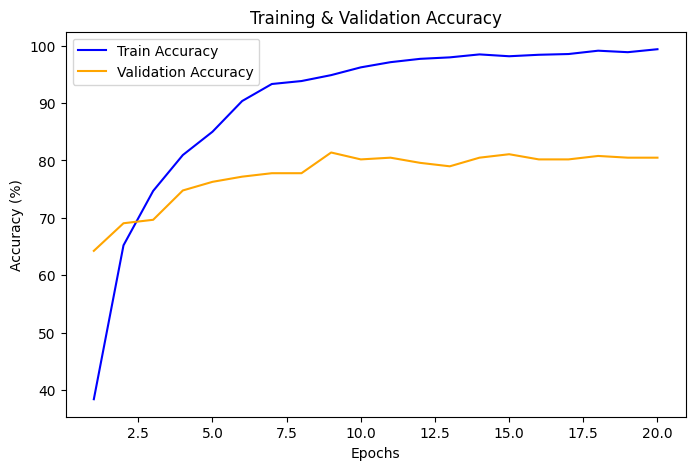

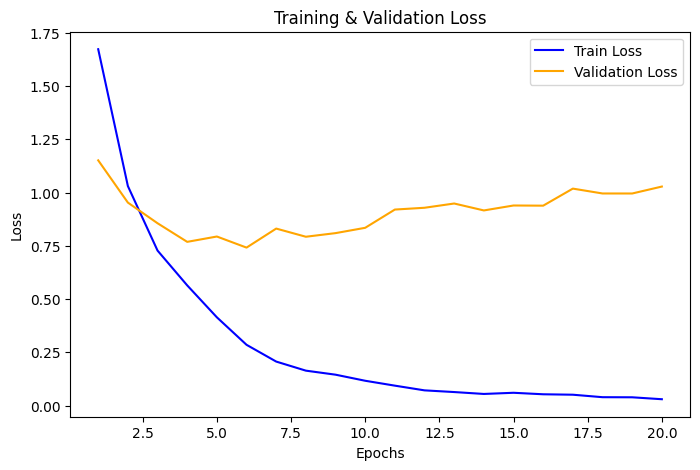

In [13]:
# Learning Rate: 0.001
# Epoches: 20
# Batch Size: 32
# Kernel Size: 5x5
model6 = GestureCNN2()
train_model(model6, train_dataset, valid_dataset, epochs=20,
            learning_rate=0.001, batch_size=32, checkpoint_path="model6.pth")

Epoch 1/20: Train Loss: 1.7888, Train Acc: 35.54%, Val Loss: 1.2969, Val Acc: 55.86%, Time: 36.26s
Checkpoint saved at epoch 1
Epoch 2/20: Train Loss: 1.1337, Train Acc: 62.72%, Val Loss: 1.0350, Val Acc: 63.66%, Time: 42.89s
Checkpoint saved at epoch 2
Epoch 3/20: Train Loss: 0.8250, Train Acc: 73.21%, Val Loss: 0.9204, Val Acc: 69.97%, Time: 35.33s
Checkpoint saved at epoch 3
Epoch 4/20: Train Loss: 0.6155, Train Acc: 79.01%, Val Loss: 0.9006, Val Acc: 71.77%, Time: 36.49s
Checkpoint saved at epoch 4
Epoch 5/20: Train Loss: 0.4776, Train Acc: 84.35%, Val Loss: 0.9371, Val Acc: 73.87%, Time: 36.66s
Checkpoint saved at epoch 5
Epoch 6/20: Train Loss: 0.3261, Train Acc: 89.63%, Val Loss: 0.8286, Val Acc: 77.78%, Time: 36.64s
Checkpoint saved at epoch 6
Epoch 7/20: Train Loss: 0.2625, Train Acc: 91.44%, Val Loss: 0.7942, Val Acc: 80.48%, Time: 36.36s
Checkpoint saved at epoch 7
Epoch 8/20: Train Loss: 0.1980, Train Acc: 93.95%, Val Loss: 0.8598, Val Acc: 79.58%, Time: 36.40s
Epoch 9/20: 

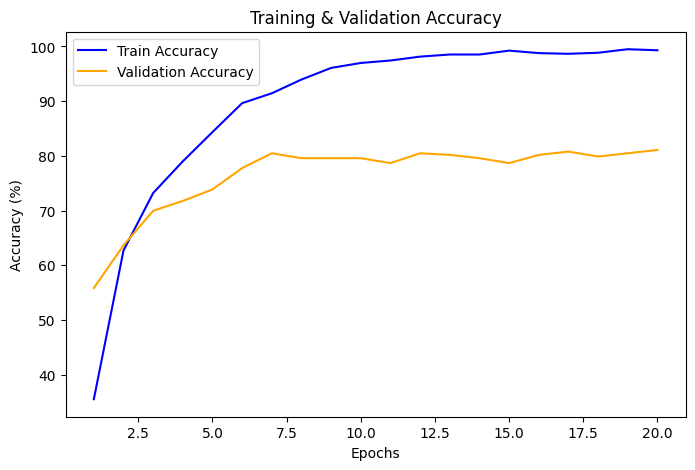

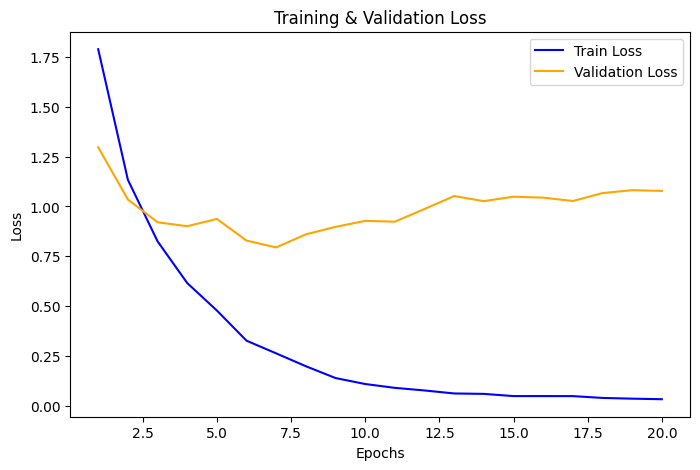

In [14]:
# Learning Rate: 0.001
# Epoches: 20
# Batch Size: 64
# Kernel Size: 5x5
model7 = GestureCNN2()
train_model(model7, train_dataset, valid_dataset, epochs=20,
            learning_rate=0.001, batch_size=64, checkpoint_path="model7.pth")

Epoch 1/20: Train Loss: 2.0997, Train Acc: 22.09%, Val Loss: 1.6224, Val Acc: 45.05%, Time: 35.97s
Checkpoint saved at epoch 1
Epoch 2/20: Train Loss: 1.5187, Train Acc: 47.26%, Val Loss: 1.2602, Val Acc: 57.96%, Time: 34.11s
Checkpoint saved at epoch 2
Epoch 3/20: Train Loss: 1.1427, Train Acc: 59.63%, Val Loss: 1.0668, Val Acc: 60.96%, Time: 35.37s
Checkpoint saved at epoch 3
Epoch 4/20: Train Loss: 0.9407, Train Acc: 67.48%, Val Loss: 0.9665, Val Acc: 67.57%, Time: 34.79s
Checkpoint saved at epoch 4
Epoch 5/20: Train Loss: 0.7840, Train Acc: 73.47%, Val Loss: 0.9320, Val Acc: 68.77%, Time: 34.65s
Checkpoint saved at epoch 5
Epoch 6/20: Train Loss: 0.6364, Train Acc: 78.88%, Val Loss: 0.8461, Val Acc: 74.17%, Time: 34.60s
Checkpoint saved at epoch 6
Epoch 7/20: Train Loss: 0.5171, Train Acc: 82.49%, Val Loss: 0.7939, Val Acc: 74.47%, Time: 34.44s
Checkpoint saved at epoch 7
Epoch 8/20: Train Loss: 0.4180, Train Acc: 86.03%, Val Loss: 0.8217, Val Acc: 76.28%, Time: 36.40s
Checkpoint s

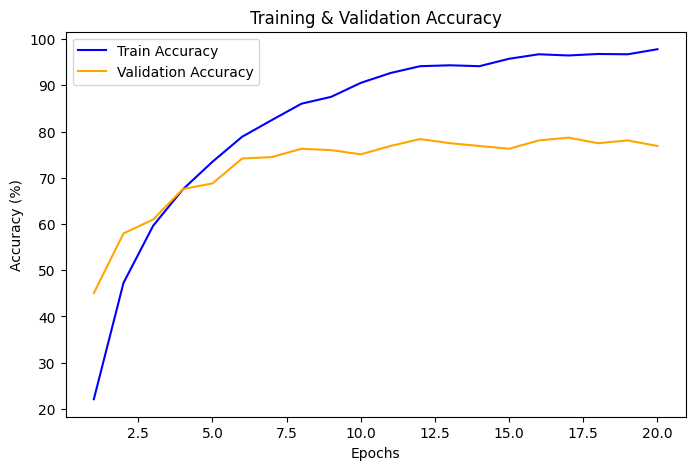

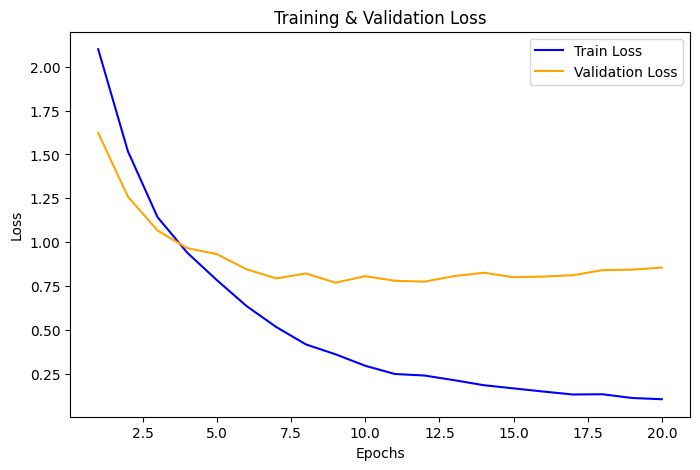

In [15]:
# Learning Rate: 0.001
# Epoches: 20
# Batch Size: 128
# Kernel Size: 5x5
model8 = GestureCNN2()
train_model(model8, train_dataset, valid_dataset, epochs=20,
            learning_rate=0.001, batch_size=128, checkpoint_path="model8.pth")

### Part (c) - 3 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

The run with model7 is the best model, which has learning rate set to 0.001, number of epoches set to 20, batch_size set to 64, and kernel size set to 5x5, because it has the highest validation accuracy. We can also see from the plot that the graph enters a plateau near the end, which probably means that it enters the "optimal zone."

### Part (d) - 4 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [16]:
def evaluate_test_accuracy(model, test_dataset, batch_size=64, checkpoint_path="model7.pth"):
    # Create test DataLoader
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load best model weights
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()

    # Initialize counters
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    return test_accuracy

In [18]:
best_test_accuracy = evaluate_test_accuracy(model7, test_dataset, batch_size=64, checkpoint_path="model7.pth")

<ipython-input-16-fbbd63db893e>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


Test Accuracy: 81.38%


### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [ ]:
# Freeze convolutional layers (we don't want to update their weights)
for param in alexnet.features.parameters():
    param.requires_grad = False

# Define transformations to match AlexNet input size and normalization
alexnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # AlexNet expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Apply transformation to dataset
train_dataset.transform = alexnet_transform
valid_dataset.transform = alexnet_transform
test_dataset.transform = alexnet_transform

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Function to extract features
def extract_features(dataloader, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode

    features_list, labels_list = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            features = model.features(images)  # Extract convolutional features
            features = features.view(features.size(0), -1)  # Flatten feature maps
            features_list.append(features.cpu())
            labels_list.append(labels.cpu())

    return torch.cat(features_list), torch.cat(labels_list)

# Extract features for train, validation, and test sets
train_features, train_labels = extract_features(train_loader, alexnet)
val_features, val_labels = extract_features(val_loader, alexnet)
test_features, test_labels = extract_features(test_loader, alexnet)

# Print extracted feature sizes
print(f"Train features shape: {train_features.shape}")
print(f"Validation features shape: {val_features.shape}")
print(f"Test features shape: {test_features.shape}")

Train features shape: torch.Size([1553, 2304])
Validation features shape: torch.Size([333, 2304])
Test features shape: torch.Size([333, 2304])


**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [ ]:
torch.save(train_features, "train_features.pt")
torch.save(train_labels, "train_labels.pt")
torch.save(val_features, "val_features.pt")
torch.save(val_labels, "val_labels.pt")
torch.save(test_features, "test_features.pt")
torch.save(test_labels, "test_labels.pt")

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Alex(nn.Module):
    def __init__(self):
        super(Alex, self).__init__()

        # Convolutional layers (expects input: batch_size, 256, 3, 3)
        self.conv1 = nn.Conv2d(256, 30, kernel_size=2)
        self.conv2 = nn.Conv2d(30, 10, kernel_size=2)

        self.fc1 = nn.Linear(10, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        batch_size = x.size(0)

        x = x.view(batch_size, 256, 3, 3)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        x = x.view(batch_size, -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

The Alex CNN model has two convolutional layers followed by two fully connected layers. Input features (256 × 3 × 3) pass through Conv2D layers (256→30→10 channels) with ReLU activations, extracting spatial features. The output is flattened and processed by fc1 (10→32) and fc2 (32→9) for classification. No pooling layers are used due to the small spatial size (3×3), making the model efficient for refining AlexNet-extracted features.

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [ ]:
import numpy as np

# Convert extracted features to NumPy and back to PyTorch tensors
train_features = torch.tensor(train_features.numpy(), dtype=torch.float32)
train_labels = torch.tensor(train_labels.numpy(), dtype=torch.long)

val_features = torch.tensor(val_features.numpy(), dtype=torch.float32)
val_labels = torch.tensor(val_labels.numpy(), dtype=torch.long)

test_features = torch.tensor(test_features.numpy(), dtype=torch.float32)
test_labels = torch.tensor(test_labels.numpy(), dtype=torch.long)

In [ ]:
import torch
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, DataLoader

def train_alex(model, train_features, train_labels, val_features, val_labels,
                epochs=20, learning_rate=0.001, batch_size=32,
               checkpoint_path="best_alexcnn.pth"):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Create TensorDatasets and DataLoaders
    train_dataset = TensorDataset(train_features, train_labels)
    val_dataset = TensorDataset(val_features, val_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Learning rate scheduler (reduces LR every 5 epochs)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # Track metrics
    train_losses, val_losses, train_acc, val_acc = [], [], [], []
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        start_time = time.time()

        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # Compute Train Loss & Accuracy
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracy = 100 * correct / total
        train_acc.append(train_accuracy)

        # Validation Phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracy = 100 * val_correct / val_total
        val_acc.append(val_accuracy)

        end_time = time.time()

        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, Time: {end_time - start_time:.2f}s")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Best model saved at epoch {epoch+1}")

        # Step the learning rate scheduler
        scheduler.step()

    # Plot Training & Validation Accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), train_acc, label="Train Accuracy", color="blue")
    plt.plot(range(1, epochs + 1), val_acc, label="Validation Accuracy", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.title("Training & Validation Accuracy Curve")
    plt.show()

    # Plot Training and Validation Loss
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), train_losses, label="Train Loss", color="blue")
    plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Loss Curve")
    plt.show()


Epoch 1/20: Train Loss: 2.0387, Train Acc: 17.26%, Val Loss: 1.6867, Val Acc: 36.34%, Time: 0.08s
Best model saved at epoch 1
Epoch 2/20: Train Loss: 1.3063, Train Acc: 56.66%, Val Loss: 0.9730, Val Acc: 64.26%, Time: 0.08s
Best model saved at epoch 2
Epoch 3/20: Train Loss: 0.7580, Train Acc: 76.50%, Val Loss: 0.7180, Val Acc: 75.98%, Time: 0.08s
Best model saved at epoch 3
Epoch 4/20: Train Loss: 0.5512, Train Acc: 82.68%, Val Loss: 0.5288, Val Acc: 82.58%, Time: 0.08s
Best model saved at epoch 4
Epoch 5/20: Train Loss: 0.3943, Train Acc: 88.15%, Val Loss: 0.4342, Val Acc: 84.98%, Time: 0.08s
Best model saved at epoch 5
Epoch 6/20: Train Loss: 0.3226, Train Acc: 90.08%, Val Loss: 0.3926, Val Acc: 88.29%, Time: 0.08s
Best model saved at epoch 6
Epoch 7/20: Train Loss: 0.2864, Train Acc: 91.95%, Val Loss: 0.3647, Val Acc: 88.89%, Time: 0.08s
Best model saved at epoch 7
Epoch 8/20: Train Loss: 0.2647, Train Acc: 92.34%, Val Loss: 0.3642, Val Acc: 89.19%, Time: 0.08s
Best model saved at 

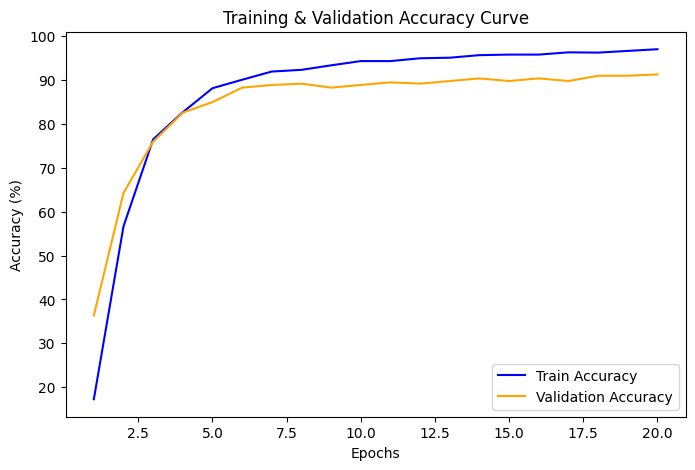

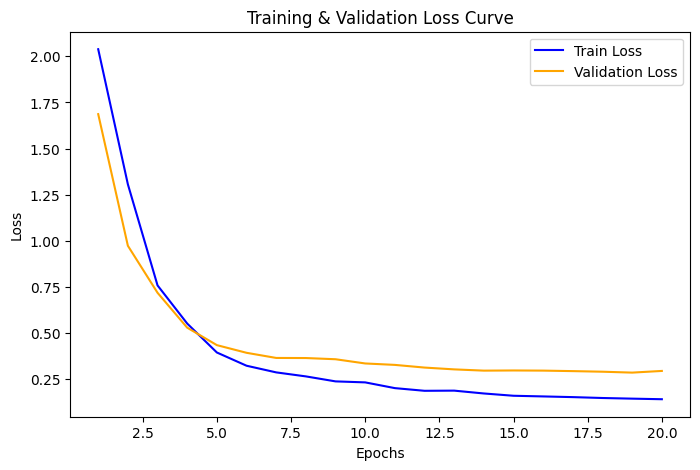

In [ ]:
alex1 = Alex()
train_alex(alex1, train_features, train_labels, val_features, val_labels,
            epochs=20, learning_rate=0.001, batch_size=64,
            checkpoint_path="alex1.pth")

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [ ]:
def evaluate_test_accuracy(model, test_features, test_labels, batch_size=32, checkpoint_path="best_alexcnn.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the best saved model
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()

    # Create DataLoader for test set
    test_dataset = TensorDataset(test_features, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    correct, total = 0, 0

    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    return test_accuracy

In [ ]:
test_accuracy = evaluate_test_accuracy(alex1, test_features, test_labels, batch_size=64, checkpoint_path="alex1.pth")

Test Accuracy: 92.19%


<ipython-input-218-123cbf34ea3b>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


The test accuracy of the best transfer learning model (92.19%) is much better than the one in Part 3(d) without transfer learning (81.38%)

In [19]:
%%shell
jupyter nbconvert --to html /content/Lab3_Gesture_Recognition.ipynb

[NbConvertApp] Converting notebook /content/Lab3_Gesture_Recognition.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 18 image(s).
[NbConvertApp] Writing 1202772 bytes to /content/Lab3_Gesture_Recognition.html
